# The Churning Ring of Fire

In [1]:
#Importing Functions and Libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('nipy_spectral')
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import pydataset as data

from acquire import get_telco_data
from prepare import clean_telco_data, prep_telco_data

from env import get_db_url

α = .05

# What's the Plan, Stan?

- ReadMe can be found here (add link), containing a data dictionary, project goals, and some initial hypotheses. about drivers of customer churn. 
- Acquire data via pre-written scripts to pull from Codeup's database.
- Prepare data via pre-written scripts for EDA and modeling.
- Establish two hypotheses and their corresponding null hypotheses, run tests to determine whether we can reject those nulls. Document finding for reference.
- Establish and document a baseline accuracy to which we can compare our eventual models.
- Train classification models.
- Evaluate models on train and test samples. 
- Evaluate best model on test sample.
- Create CSV file containing customer ID, our model's prediction of whether they will churn, and the expected probability that will be the case. 
- Document conclusios, key insights, and recommendations.

# The Gregxecutive Summary:

- Of the 4 types of models I ran (Decision Tree, Random Forest, K Nearest Neighbors, and Logistic Regression), the Random Forest performed best, with an ultimate test accuracy of ~ 82%.
- This model outperforms the baseline prediction by ~ 9%.
- Given more time in the future, I would like to run some multivariate analysis to control for certain features in order to determine which relationships are truly causal in nature. 

# Acquiring and Preparing the Data:

In [2]:
# Acquiring Data:
telco_df = get_telco_data()

#Splitting Data in to Train, Validate, and Test Sets:
train, validate, test = prep_telco_data(telco_df)
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
3270,4673-KKSLS,Female,No,No,No,31,Yes,No,Yes,No,...,0,0,0,0,0,0,1,0,1,0
6084,8623-ULFNQ,Female,Yes,No,No,26,Yes,Yes,No,No,...,0,1,1,0,0,0,1,0,0,0
4470,6303-KFWSL,Female,No,No,No,29,Yes,Yes,No,Yes,...,0,0,1,1,0,0,1,0,0,0
428,0623-IIHUG,Female,Yes,No,No,21,No,No phone service,Yes,No,...,0,0,1,0,0,0,1,0,0,0
3329,4742-DRORA,Male,No,Yes,Yes,60,Yes,Yes,Yes,No,...,0,0,1,1,0,0,0,0,1,0


In [3]:
#Creating train, validate, and test sets:
#Creating X and y model-testing dataframes:
X_train = train.drop(columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection',
 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'payment_type', 'internet_service_type'])
y_train = train.churn

X_validate = validate.drop(columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection',
 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'payment_type', 'internet_service_type'])
y_validate = validate.churn

X_test = test.drop(columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection',
 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'contract_type', 'payment_type', 'internet_service_type'])
y_test = test.churn

## Acquire & Prepare Takeaways: 

- There were 11 nulls to be removed (these customers have not completed a full billing cycle)
- I dropped contract_type_id, payment_type_id, and internet_service_type_id, as they were replaced with dummy columns for modeling.
- Split into train, validate, and test, stratifying on churn column.

# Exploration:

### What Proportion of Customers Churned Last Month?

<AxesSubplot:title={'center':'How Many Customers Churned?'}, xlabel='churn', ylabel='Count'>

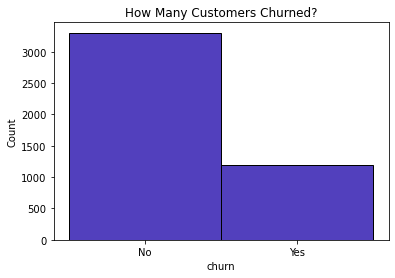

In [4]:
plt.title("How Many Customers Churned?")
sns.histplot(train, x = 'churn', legend = True)

In [5]:
(train[train.churn == 'Yes'].count().churn / train.churn.shape[0]) * 100

26.57777777777778

- Around 26.6% of customer churned this month.

### What Is the Relationship Between Multiple Lines and Churn?

[Text(0.5, 1.0, 'Are Customers With Multiple Lines More Likely to Churn? Spoiler: No!')]

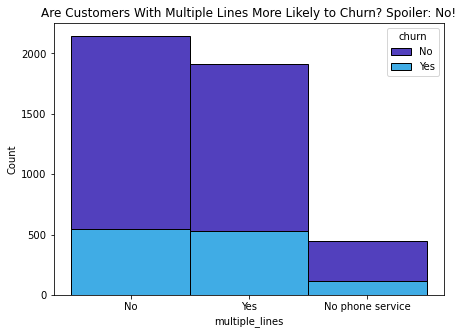

In [29]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="multiple_lines", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Are Customers With Multiple Lines More Likely to Churn? Spoiler: No!")

#### Statistical Testing
- $H_0$: Customers with multiple lines are equally or less likely to churn.
- $H_a$: Customers with multiple lines are more likely to churn.

In [7]:
multiple_line_hypothesis = train[['multiple_lines', 'churn']]
multiple_line_hypothesis['multiple_lines_boolean'] = (train['multiple_lines'] == 'Yes')
#multiple_line_hypothesis

multi_line_contingency_table = pd.crosstab(multiple_line_hypothesis.churn, multiple_line_hypothesis.multiple_lines_boolean)

chi2, p, degf, expected = stats.chi2_contingency(multi_line_contingency_table)

p < α

False

##### Conclusion:
- We cannot reject the null that customers with multiple lines are equally or less likely to churn. 

##### Takeaway:
- Current evidence does *not* indicate that customers with multiple lines are more likely to churn.

### What is the Relationship Between Internet Service Type and Churn?

[Text(0.5, 1.0, 'Are Customers With Fiber More Likely to Churn? Spoiler: Yes!')]

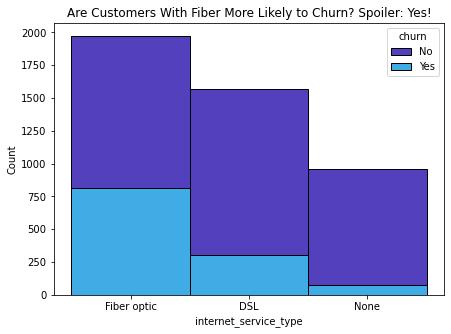

In [28]:
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

sns.histplot(data= train, ax=ax, stat="count", multiple="stack",
             x="internet_service_type", kde=False, hue="churn",
             element="bars", legend=True).set(Title = "Are Customers With Fiber More Likely to Churn? Spoiler: Yes!")

#### Statistical Testing
- $H_0$: Customers with fiber optic internet are equally or less likely to churn.
- $H_a$: Customers with fiber optic internet are more likely to churn.

In [9]:
fiber_optic_hypothesis = train[['internet_service_type', 'churn']]
fiber_optic_hypothesis['fiber_optic'] = (train['internet_service_type'] == 'Fiber optic')
#fiber_optic_hypothesis

contingency_table = pd.crosstab(fiber_optic_hypothesis.churn, fiber_optic_hypothesis.fiber_optic)

chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

p < α

True

##### Conclusion:
- We can reject the null that customers with fiber optic internet are equally or less likely to churn. 

##### Takeaway:
- Customers with fiber optic internet are more likely to churn.

# Best 3 Models:

## Decision Tree:
- max_depth = 4

In [10]:
#Creating the object and fitting the model:
tree = DecisionTreeClassifier(max_depth=4, random_state=123)
tree = tree.fit(X_train, y_train)

### In-Sample Accuracy is ~ 78.3%

In [11]:
#Performance on In-Sample Data:
dt_in_sample_accuracy = tree.score(X_train, y_train)
dt_in_sample_accuracy

0.7828888888888889

### Out-of-Sample Accuracy is ~ 80.5%

In [12]:
#Performance on Out-of-Sample Data:
dt_out_of_sample_accuracy = tree.score(X_validate, y_validate)
dt_out_of_sample_accuracy

0.8053333333333333

## Random Forest:
- min_samples_per_leaf = 10
- max_depth = 10

In [13]:
#Creating the object and fitting the model:
rf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 10, random_state = 123)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, random_state=123)

### In-Sample Accuracy is ~ 81.4%

In [14]:
#Performance on In-Sample Data:
rf_in_sample_accuracy = rf.score(X_train, y_train)
rf_in_sample_accuracy

0.8135555555555556

### Out-of-Sample Accuracy is ~ 81.5%

In [15]:
#Performance on Out-of-Sample Data:
rf_out_of_sample_accuracy = rf.score(X_validate, y_validate)
rf_out_of_sample_accuracy

0.8151111111111111

## K-Nearest Neighbors (KNN):
- k = 18

In [16]:
#Creating the model object and fitting the data:
knn = KNeighborsClassifier(n_neighbors=18, weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=18)

### In-Sample Accuracy is ~ 80.1%

In [17]:
knn_in_sample_accuracy = knn.score(X_train, y_train)
knn_in_sample_accuracy

0.8008888888888889

### Out-of-Sample Accuracy is ~ 80.4%

In [18]:
knn_out_of_sample_accuracy = knn.score(X_validate, y_validate)
knn_out_of_sample_accuracy

0.8035555555555556

# Testing With the Best Model:
- The best model appeared to be the Random Forest model, we'll use that on our test data

## Test Accuracy is ~ 82.0%

In [19]:
rf_test_sample_accuracy = rf.score(X_test, y_test)
rf_test_sample_accuracy

0.8194740582800284

## Visualizing Model Performance Relative to Differing Hyperparameters:

In [21]:
# Writing a loop to visualize best model's performance in relation to different hyper parameters:
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Evaluate model's performance:
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy

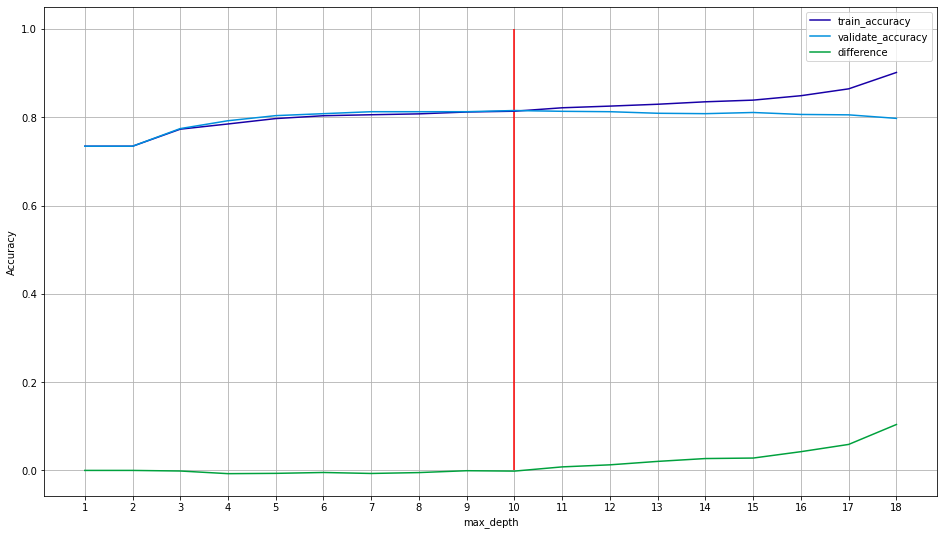

In [22]:
df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.vlines(x = 10, ymin = 0, ymax = 1, colors = 'r', linestyles = 'solid')

#### Takeaway:
- This graph shows the point at which the train and validate accuracies have the smallest difference, but with the highest accuracy. This is how a model with a max_depth of 10 came to be selected.

# Sending the predictions to a CSV:

In [27]:
y_predictions = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)

#Creating empty DataFrame:
predictions = pd.DataFrame()
#Creating customer_id column:
predictions['customer_id'] = test.customer_id
#Creating prediction column:
predictions['prediction'] = y_predictions
#Creating probability column:
predictions['probability'] = y_proba[:,1]

predictions.to_csv("predictions.csv")